# Tutorials

In this notebook you will find some examples of code to help you write your own algorithms using the `qibo` library.

## Circuit definition and execution

You can learn more about `qibo` quantum circuits in their [official documentation](https://qibogang.github.io/qibo/stable/code-examples/examples.html#)

In [3]:
# Import all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

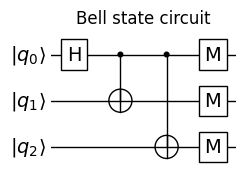

Final state = (0.70711+0j)|000> + (0.70711+0j)|111>

Final statevector:
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [20]:
# We will create a quantum circuit to generate a Bell state

circuit = models.Circuit(3)

# Add the gates of the circuit
circuit.add(gates.H(0))
circuit.add(gates.CNOT(0, 1))
circuit.add(gates.CNOT(0, 2))

circuit.add(gates.M(i) for i in range(3))

# We can plot the circuit with
ax, fig = plot_circuit(circuit)
ax.set_title("Bell state circuit")
plt.show()

# And the circuit can be simulated with
final_state = circuit()
print(f'Final state = {final_state}\n')

# And the statevector of the final state:
final_statevector = final_state.state()
print(f'Final statevector:\n{final_statevector}')

Note that the bitstrings of the states tell us in which element of the statevector we will find the corresponding coefficient.

Coefficient for the state $|000\rangle \rightarrow 0$ can be found in the element 0 of the statevector (`final_statevector[0]`)

Coefficient for the state $|010\rangle \rightarrow 2$ can be found in the element 2 of the statevector (`final_statevector[2]`)

Coefficient for the state $|111\rangle \rightarrow 7$ can be found in the element 7 of the statevector (`final_statevector[7]`)

In [41]:
# The probability of measuring each state will be the norm squared of each coefficient, it can be automatically calculated with
probabilities = final_state.probabilities()
print(f'Vector of probabilities = {probabilities}')

Vector of probabilities = [0.25 0.   0.   0.   0.   0.   0.   0.75]


Parametrized gates: now we will generate a superposition of 25% state |000> and 75% state |111> by using a parametrized rotation $R_y(\theta)$

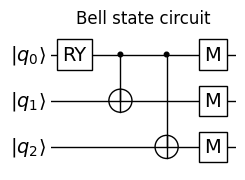

Final state = (0.5+0j)|000> + (0.86603+0j)|111>

Probabilities: [0.25 0.   0.   0.   0.   0.   0.   0.75]


In [40]:
circuit = models.Circuit(3)

# Add the gates of the circuit
theta = 2*np.pi/3 # The angle of rotation

circuit.add(gates.RY(0, theta))
circuit.add(gates.CNOT(0, 1))
circuit.add(gates.CNOT(0, 2))

circuit.add(gates.M(i) for i in range(3))

# We can plot the circuit with
ax, fig = plot_circuit(circuit)
ax.set_title("Bell state circuit")
plt.show()

# And the circuit can be simulated with
final_state = circuit()
print(f'Final state = {final_state}\n')

print(f'Probabilities: {final_state.probabilities()}')


So far we have performed exact simulations where we have obtained the ideal final state. However, in practice we will have to execute and measure the circuit $n\_shots$ times in order to reconstruct the final state. This process can be simulated in the following way:

In [46]:
n_shots = 100

circuit = models.Circuit(3)

# Add the gates of the circuit
circuit.add(gates.H(0))
circuit.add(gates.CNOT(0, 1))
circuit.add(gates.CNOT(0, 2))

circuit.add(gates.M(i) for i in range(3))


result = circuit(nshots = n_shots) # We have to specify the number of shots when simulating the circuit


samples = result.samples() # A list of all the bitstrings measured can be recovered with this method

frequencies = result.frequencies() # A compact dictionary with the number of times that each bitstring has been measured

print(f'Count of times each state has been measured: {frequencies}')

Count of times each state has been measured: Counter({'000': 61, '111': 39})


Observe that now the probability of measuring each state differs from the exact probability of 50%.

## Adiabatic evolutions

You can find more information about `qibo`'s Adiabatic Evolutions in their [official documentation](https://qibogang.github.io/qibo/stable/code-examples/tutorials/adiabatic/README.html#)

In order to run quantum annealing algorithms we need to perform simulations of adiabatic evolutions. `qibo` has some tools for this purpose:

In [77]:
# Import all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from qibo import hamiltonians, callbacks, models
from qibo.symbols import X, Z

First we will need to define the mixing Hamiltonian and the objective Hamiltonian:

In [88]:
nqubits = 3

T = 10 # Total evolution time
dt = 0.1 # Time step

# Define the symbolic Hamiltonians
h0 = sum(X(i) for i in range(nqubits)) # We define an easy mixing Hamiltonian
h1 = 4*Z(0) + 2 * Z(2) - 6*Z(0)*Z(1) + Z(1)*Z(2) # We define a random objective Hamiltonian

# In order to get the Hamiltonian objects we need to run
sh0 = hamiltonians.SymbolicHamiltonian(h0)
sh1 = hamiltonians.SymbolicHamiltonian(h1)
# We define a simple scheduling function (the argument t is already normalized between 0 and 1)
s = lambda t: t

# The model is defined as
evolution = models.AdiabaticEvolution(sh0, sh1, s, dt)

# And the simulation can be performed obtaining the final statevector
final_statevector = evolution(final_time=T)

print(f'Final statevector = {final_statevector}')

[Qibo 0.2.12|WARNING|2024-10-05 03:09:33]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Final statevector = [-0.00330763+2.03382165e-02j  0.19727398-1.51418652e-01j
  0.00057832-3.81651255e-04j  0.01196235-3.00365993e-02j
 -0.01102123-1.29110162e-02j  0.05993728+3.69169975e-02j
  0.02332001-1.34244831e-01j -0.42714023-8.54650358e-01j]


We can get the evolution of the energy levels and other interesting quantities by passing callbacks to the evolution.

Use them only when needed, by adding at least 1 callback the algorithms has to compute the full Hamiltonian matrix at each step and the simulations becomes much more inefficient. The limit will depend on the device where you are running the code but it will probably be around $\sim 10$ qubits. Running the simulation without callbacks will be much faster, and may allow you to add a few qubits more ($\sim 12$). Trying to run a simulation with too many qubits will overload the RAM of your computer, be careful!

[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.12|WARNING|2024-10-05 03:13:51]: Calculating 

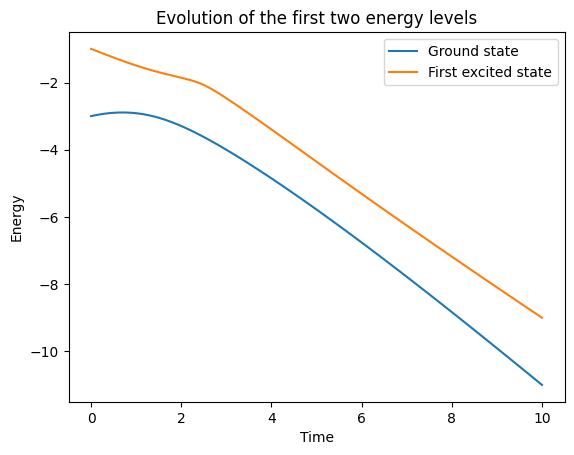

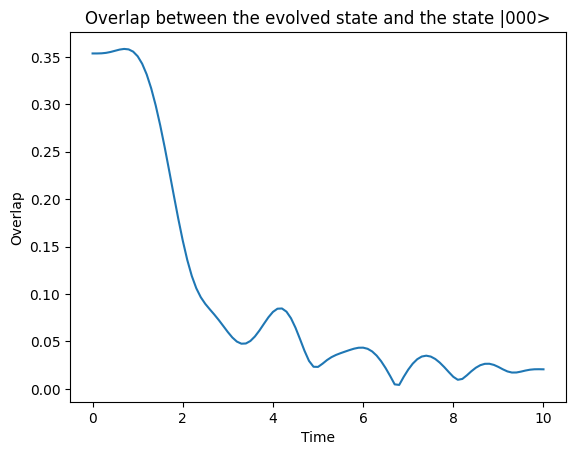

In [91]:
e0 = callbacks.Gap(0) # Callback for the Ground state
e1 = callbacks.Gap(1) # Callback for the First excited state

state_0 = np.zeros((2**nqubits,))
state_0[0] = 1
overlap = callbacks.Overlap(state_0) # Callback for the overlap between the evolved state and the state |000>

callbacks_list = [e0, e1, overlap]
evolution = models.AdiabaticEvolution(sh0, sh1, s, dt, callbacks=callbacks_list) # We pass the list of callbacks when creating the model
final_statevector = evolution(final_time=T)

# Plot the callbacks
x_ticks = [dt*i for i in range(int(T/dt)+1)]
plt.plot(x_ticks, e0[:], label='Ground state')
plt.plot(x_ticks, e1[:], label='First excited state')
plt.title('Evolution of the first two energy levels')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()

x_ticks = [dt*i for i in range(int(T/dt)+1)]
plt.plot(x_ticks, overlap[:])
plt.title('Overlap between the evolved state and the state |000>')
plt.xlabel('Time')
plt.ylabel('Overlap')
plt.show()

With `qibo` Hamiltonians it is quite easy to compute the expected value of some Hamiltonian with a given state

In [95]:
# We will compute the expected value of the state |000> with both Hamiltonians

print(f'Mixing Hamiltonian: <000|H_M|000> = {sh0.expectation(state_0)}')
print(f'Objective Hamiltonian: <000|H_P|000> = {sh1.expectation(state_0)}')

Mixing Hamiltonian: <000|H_M|000> = 0.0
Objective Hamiltonian: <000|H_P|000> = 1.0
